In [9]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa to handle audio files
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
#the path of file and generals
import os
general_path = '../input/gtzan-dataset-music-genre-classification/Data'
genres = list(os.listdir(f'{general_path}/genres_original/'))
genres

['disco',
 'metal',
 'reggae',
 'blues',
 'rock',
 'classical',
 'jazz',
 'hiphop',
 'country',
 'pop']

# Explore Audio Data

We will use `librosa`, which is the mother of audio files.

## Understanding Audio
Let's first Explore our Audio Data to see how it looks (we'll work with `reggae.00036.wav` file).

* **Sound**: sequence of vibrations in varying pressure strengths (`y`)
* The **sample rate** (`sr`) is the number of samples of audio carried per second, measured in Hz or kHz

In [11]:
# Importing 1 file
sound_sequence, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('sound_sequence:', sound_sequence, '\n')
print('sound_sequence shape:', np.shape(sound_sequence), '\n')
print('Sample Rate (KHz):', sr, '\n')

sound_sequence: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

sound_sequence shape: (661794,) 

Sample Rate (KHz): 22050 



In [12]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(sound_sequence)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


### 2D Representation: Sound Waves

Text(0.5, 1.0, 'Sound Waves in Reggae 36')

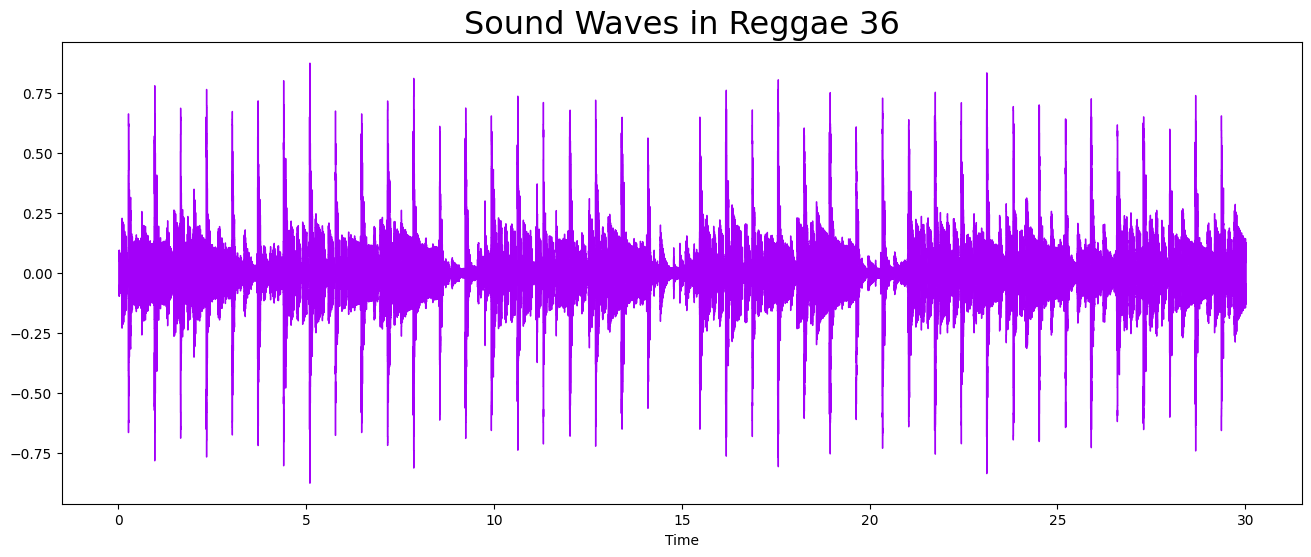

In [13]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23)

## EDA

EDA is going to be performed on the `features_30_sec.csv`. This file contains the mean and variance for each audio file fo the features analysed above. 

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [14]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Correlation Heatmap for feature means

# Machine Learning Classification

Using the `features_3_sec.csv` file, we can try to build a classifier that accurately predicts for any new audio file input it's genre.

### Libraries

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

### Reading in the Data

Now let's try to predict the Genre of the audio using Machine Learning techniques.

In [16]:
data_all = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data_all.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### Features and Target variable

* creates the target and feature variables
* normalizes the data

In [17]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels
X = np.asarray(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# NN Model (baseline model)

In [19]:
epochs_num = 20
batch_size = 5

baseline_model = Sequential()

baseline_model.add(Dense(120, input_dim=np.shape(X)[1], activation='relu'))
baseline_model.add(Dropout(0.25))
baseline_model.add(Dense(64, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
baseline_model.add(Dropout(0.25))
baseline_model.add(Dense(len(genres), activation='softmax'))
baseline_model.summary()
# Compile the model
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               7080      
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                7744      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 15,474
Trainable params: 15,474
Non-trainable params: 0
_________________________________________________________________


In [20]:
y_test = [genres.index(y) for y in y_test]
y_test = np.array(y_test)

y_train = [genres.index(y) for y in y_train]
y_train = np.array(y_train)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [21]:
history = baseline_model.fit(X_train, y_train, epochs=epochs_num, batch_size=batch_size)

Epoch 1/20
1399/1399 [==============================] - 4s 2ms/step - loss: 0.2976 - accuracy: 0.3126
Epoch 2/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.2479 - accuracy: 0.4341
Epoch 3/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.2307 - accuracy: 0.4939
Epoch 4/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.2199 - accuracy: 0.5238
Epoch 5/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.2113 - accuracy: 0.5520
Epoch 6/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.2053 - accuracy: 0.5709
Epoch 7/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.1992 - accuracy: 0.5906
Epoch 8/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.1947 - accuracy: 0.6010
Epoch 9/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.1907 - accuracy: 0.6075
Epoch 10/20
1399/1399 [==============================] - 3s 2ms/step - loss: 0.186

In [22]:
y_pred = baseline_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("NN accuracy : ", (round(accuracy_score(y_test, y_pred), 3)) * 100, "%")

94/94 [==============================] - 0s 1ms/step
NN accuracy :  62.3 %


# KNN model - Cross Validation

In [23]:
knn = KNeighborsClassifier(n_neighbors=len(genres))
num_folds = 5 # number of folds

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

fold_no = 1
y = np.array(y)
kfold = KFold(n_splits=num_folds, shuffle=True)
for train, test in kfold.split(X, y): 
    print(f'Fold No.{fold_no}')
    knn.fit(X[train], y[train])
    
    preds = knn.predict(X[test])
    acc = (round(accuracy_score(y[test], preds), 3)) * 100
    print('KNN Accuracy : ', acc, '%')
    print("---------------------------")
    
    fold_no = fold_no + 1

Fold No.1
KNN Accuracy :  86.0 %
---------------------------
Fold No.2
KNN Accuracy :  88.3 %
---------------------------
Fold No.3
KNN Accuracy :  86.9 %
---------------------------
Fold No.4
KNN Accuracy :  86.9 %
---------------------------
Fold No.5
KNN Accuracy :  86.7 %
---------------------------


# Random Forest model - Train and Test

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf.fit(X_train, y_train)

preds = rf.predict(X_test)

acc = round(accuracy_score(y_test, preds) * 100, 3)
print('Random Forest Accuracy:', acc, '%')


Random Forest Accuracy: 87.538 %


# Random Forest model - Cross Validation

In [18]:
rf = RandomForestClassifier(n_estimators=100)

num_folds = 5 # number of folds
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=True)

for train, test in kfold.split(X, y): 
    print(f'Fold No.{fold_no}')  
    rf.fit(X[train], y[train])  
    
    preds = rf.predict(X[test])
    acc = (round(accuracy_score(y[test], preds), 3)) * 100
    print('Random Forest Accuracy : ', acc, '%')
    print("---------------------------")
    
    fold_no = fold_no + 1


Fold No.1
Random Forest Accuracy :  86.6 %
---------------------------
Fold No.2
Random Forest Accuracy :  87.5 %
---------------------------
Fold No.3
Random Forest Accuracy :  86.2 %
---------------------------
Fold No.4
Random Forest Accuracy :  86.7 %
---------------------------
Fold No.5
Random Forest Accuracy :  86.6 %
---------------------------


# Trying Naive Bayes and SVM

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


nb = GaussianNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)

acc = round(accuracy_score(y_test, preds) * 100, 3)
print('Naive Bayes Accuracy:', acc, '%')


svm = SVC()
svm.fit(X_train, y_train)

preds = svm.predict(X_test)

acc = round(accuracy_score(y_test, preds) * 100, 3)
print('SVM Accuracy:', acc, '%')


In [26]:
 row_index = int(input("Enter the index of the row you want to predict (0 to {}): ".format(len(data) - 1)))

selected_row = X[row_index]
selected_row = np.reshape(selected_row, (1, -1))
selected_row = scaler.transform(selected_row)


selected_filename = data_all.loc[row_index, 'filename']
filename_parts = selected_filename.split('.')
real_type = filename_parts[0]
print("\nThe real type is :", real_type,"\n")




nn_prediction = baseline_model.predict(selected_row)
nn_prediction = np.argmax(nn_prediction, axis=1)
nn_genre = genres[nn_prediction[0]]

knn_prediction = knn.predict(selected_row)
knn_genre = knn_prediction[0]

rf_prediction = rf.predict(selected_row)
rf_genre = rf_prediction[0]

print("Neural Network Prediction:", nn_genre)
print("K-Nearest Neighbors Prediction:", knn_genre)
print("Random Forest Prediction:", rf_genre)


Enter the index of the row you want to predict (0 to 9989):  1231



The real type is : classical 

1/1 [==============================] - 0s 31ms/step
Neural Network Prediction: blues
K-Nearest Neighbors Prediction: disco
Random Forest Prediction: classical


In [28]:
print(selected_row)

[[-6.6149000e+04  3.6464757e-01  6.4246974e+00  9.3451262e-01
   2.0393996e+00 -9.5203854e-02 -1.6937044e-04 -1.5529940e-01
  -9.5910602e-04 -7.4480720e-02 -8.8204164e-05  9.8725265e-01
   6.9526643e-01  1.5445850e+01  1.4446243e+00  3.1276585e+01
   1.1032022e+00 -9.1354087e-02  8.6087960e-01 -5.5929017e-04
   4.6751577e-02 -1.8818916e-03  5.6670189e-01 -4.9044756e-04
   2.8517321e-01 -1.5223831e-03  5.1139814e-01 -6.2808273e-03
   3.9570963e-01 -5.9416099e-03  6.3146096e-01 -1.1309687e-02
   3.8424981e-01 -1.2767289e-02  5.5835605e-01 -1.9826084e-02
   3.6383325e-01 -1.5811961e-02  4.6786270e-01 -7.1513583e-03
   3.2305038e-01 -3.8977789e-03  4.5538422e-01 -1.3563755e-02
   4.0981355e-01 -3.5086845e-03  5.3123945e-01 -2.1949364e-03
   4.1318774e-01 -1.8587584e-03  4.5583630e-01 -3.0064380e-03
   3.6462027e-01 -5.3875162e-03  4.7348741e-01 -2.6355779e-03
   5.1744485e-01 -2.2497319e-04]]
